In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

In [2]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

In [3]:
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

['73309.png', '32433.png', '14386.png', '66076.png', '30230.png', '67368.png', '73335.png', '71244.png', '43590.png', '25601.png', '71250.png', '38888.png', '75750.png', '55480.png', '12046.png', '12052.png', '99707.png', '58173.png', '19891.png', '75787.png', '80518.png', '45122.png', '51157.png', '10679.png', '42659.png', '81612.png', '62589.png', '96408.png', '28480.png', '21895.png', '30740.png', '13199.png', '72215.png', '70402.png', '93941.png', '76073.png', '17499.png', '43962.png', '11942.png', '65755.png', '73123.png', '41191.png', '63456.png', '62748.png', '16744.png', '94035.png', '91159.png', '10447.png', '21842.png', '59721.png', '11771.png', '18033.png', '59709.png', '24912.png', '81362.png', '98627.png', '43023.png', '86419.png', '52648.png', '11765.png', '36245.png', '59682.png', '24899.png', '64517.png', '12481.png', '91788.png', '15488.png', '63250.png', '75432.png', '44823.png', '20369.png', '27406.png', '61453.png', '54365.png', '14741.png', '10527.png', '13748.png'

  0%|          | 0/2662 [00:00<?, ?it/s]

In [4]:
#tracks_df.columns = pd.MultiIndex.from_product([['track'],['id']])
filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

track_id
73309             Rock
32433       Electronic
14386          Hip-Hop
66076       Electronic
30230          Hip-Hop
             ...      
5879              Folk
3763              Rock
3777     International
4781              Rock
3950              Rock
Name: genre_top, Length: 2662, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Some tracks don't have a genre

In [5]:
filtered_tracks.isna().any()

False

Check all top level genres

In [6]:
filtered_tracks.unique()

['Rock', 'Electronic', 'Hip-Hop', 'Pop', 'International', 'Experimental', 'Folk', 'Instrumental']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [7]:
filtered_tracks.loc[4037]

'Folk'

Generate directories

In [8]:
Path("dataset").mkdir(parents=True, exist_ok=True)

for genres in tqdm(filtered_tracks.unique()):
    Path("dataset/"+genres).mkdir(parents=True, exist_ok=True)

for track_id in tqdm(filtered_tracks.index):
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset/" + filtered_tracks.loc[track_id] + "/" + str(track_id) + ".png")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2662 [00:00<?, ?it/s]

In [9]:
image_size = (200, 600)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2662 files belonging to 8 classes.
Using 2130 files for training.
Metal device set to: Apple M1 Pro


2022-06-16 10:53:38.380225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-16 10:53:38.380346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2662 files belonging to 8 classes.
Using 532 files for validation.


tf.Tensor([7 2 0 6 2 4 5 3 2 2 4 1 7 0 1 1 7 3 4 5 5 5 4 7 2 1 5 4 0 1 0 4], shape=(32,), dtype=int32)


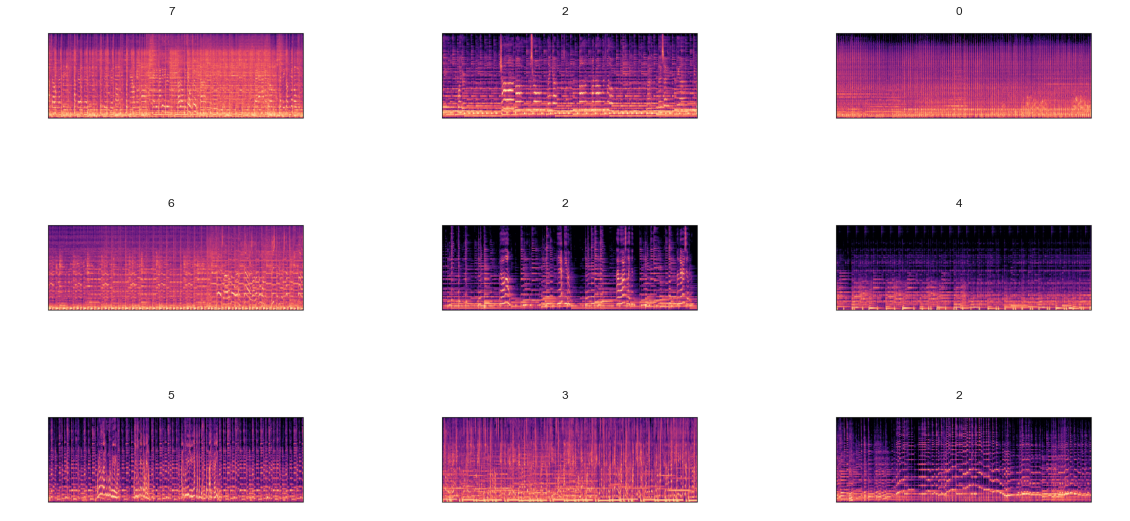

In [25]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
#with tf.device('/cpu:0'):
#    data_augmentation = keras.Sequential(
#        [
#            layers.RandomFlip("horizontal"),
#            layers.RandomRotation(0.1),
#        ]
#    )

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

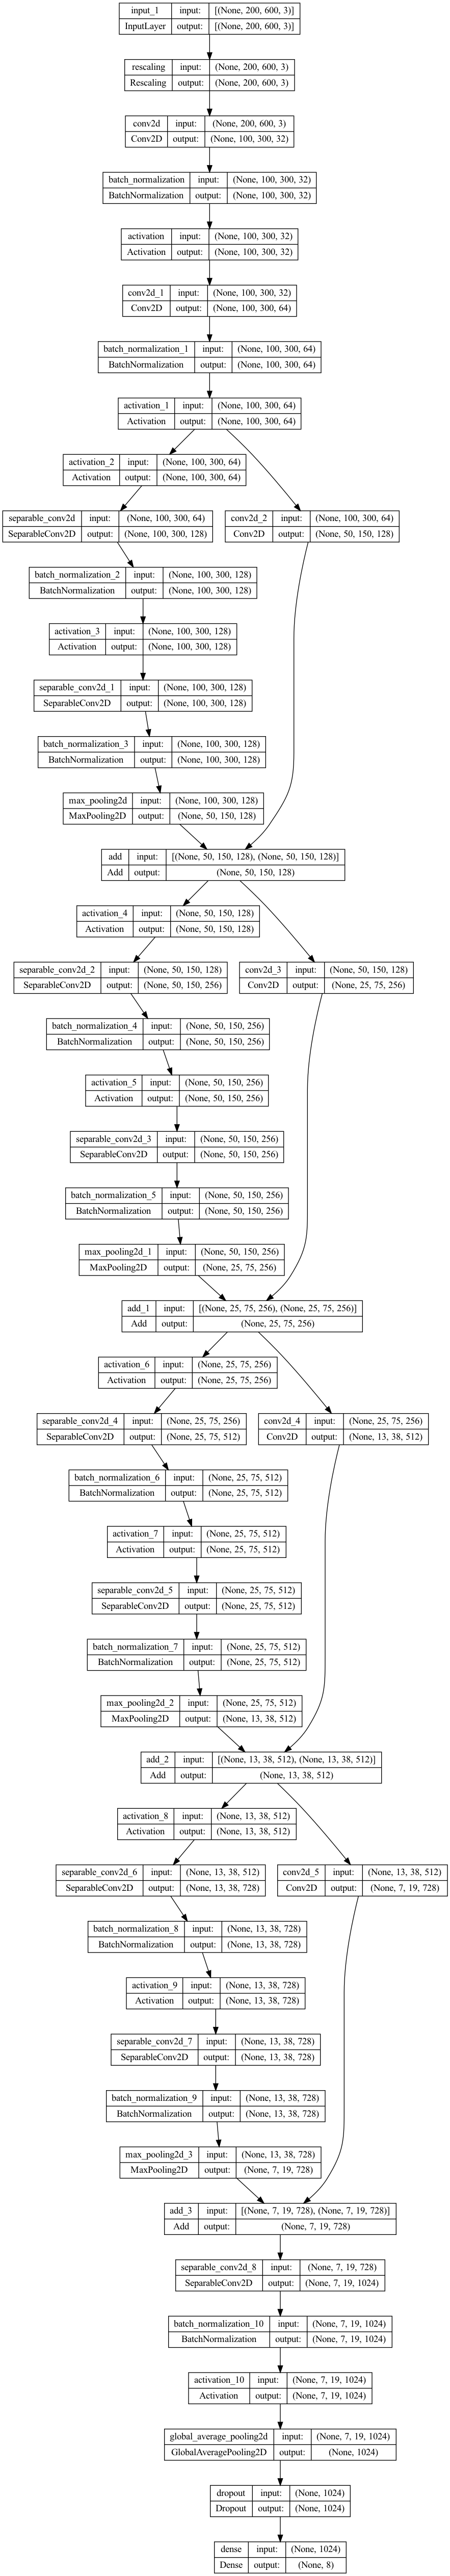

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=8)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10


2022-06-16 10:53:41.011489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.7748 - accuracy: 0.3413

2022-06-16 10:54:49.443766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 74s 1s/step - loss: 1.7748 - accuracy: 0.3413 - val_loss: 2.2497 - val_accuracy: 0.1053
Epoch 2/10
67/67 [==============================] - 75s 1s/step - loss: 1.5830 - accuracy: 0.4230 - val_loss: 3.5122 - val_accuracy: 0.1053
Epoch 3/10
67/67 [==============================] - 73s 1s/step - loss: 1.5193 - accuracy: 0.4643 - val_loss: 4.9497 - val_accuracy: 0.1053
Epoch 4/10
67/67 [==============================] - 72s 1s/step - loss: 1.4526 - accuracy: 0.4779 - val_loss: 6.0085 - val_accuracy: 0.1053
Epoch 5/10
67/67 [==============================] - 73s 1s/step - loss: 1.3632 - accuracy: 0.5300 - val_loss: 6.0908 - val_accuracy: 0.1053
Epoch 6/10
67/67 [==============================] - 74s 1s/step - loss: 1.3417 - accuracy: 0.5263 - val_loss: 5.8709 - val_accuracy: 0.1053
Epoch 7/10
67/67 [==============================] - 72s 1s/step - loss: 1.2517 - accuracy: 0.5549 - val_loss: 8.3756 - val_accuracy: 0.1053
Epoch 8/10
67/67 [=============

Epoch 1/10


2022-06-16 11:18:35.807203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 3.1759 - acc: 0.1333

2022-06-16 11:19:04.826523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 32s 434ms/step - loss: 3.1759 - acc: 0.1333 - val_loss: 2.0793 - val_acc: 0.1241
Epoch 2/10
67/67 [==============================] - 29s 422ms/step - loss: 2.0791 - acc: 0.1408 - val_loss: 2.0791 - val_acc: 0.1241
Epoch 3/10
67/67 [==============================] - 28s 413ms/step - loss: 2.0785 - acc: 0.1408 - val_loss: 2.0787 - val_acc: 0.1241
Epoch 4/10
67/67 [==============================] - 28s 414ms/step - loss: 2.0781 - acc: 0.1408 - val_loss: 2.0787 - val_acc: 0.1241
Epoch 5/10
67/67 [==============================] - 28s 413ms/step - loss: 2.0779 - acc: 0.1408 - val_loss: 2.0784 - val_acc: 0.1241
Epoch 6/10
67/67 [==============================] - 27s 409ms/step - loss: 2.0778 - acc: 0.1408 - val_loss: 2.0783 - val_acc: 0.1241
Epoch 7/10
67/67 [==============================] - 28s 416ms/step - loss: 2.0776 - acc: 0.1408 - val_loss: 2.0782 - val_acc: 0.1241
Epoch 8/10
67/67 [==============================] - 29s 427ms/step - loss: 2.077

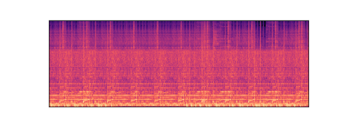

1/1 [==============================] - 0s 22ms/step


array([[0.13893174, 0.11417756, 0.11766851, 0.12809528, 0.12902974,
        0.12442338, 0.12327268, 0.12440106]], dtype=float32)

In [24]:
def load_image_pr(img_path, show=False):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(200, 600))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor


img_path = 'dataset/Hip-Hop/10696.png'    # dog

new_image = load_image_pr(img_path, show=True)
pred = model.predict(new_image)
pred
#img = tf.keras.preprocessing.image.load_img(
#    "dataset/Hip-Hop/6608.png", target_size=image_size
#)
#img_array = tf.keras.preprocessing.image.img_to_array(img)
#img_array = tf.expand_dims(img_array, 0)  # Create batch axis

#predictions = model.predict(img_array)
#predictions